In [1]:
# main data generation for the manuscript. 
# v4 will be used for data generated with improved technology, i.e., higher initial fidelities, lower probability of failure etc. 
from Qsim_v3 import *
import networkx as nx
import numpy as np
import random
from multiprocessing import Pool
from tqdm import tqdm  # Progress bar

In [2]:
import multiprocessing

print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  10


In [3]:
# Plotting function that plots once all simulations are finished
def plot_results(mode_1_fid, mode_1_rate, mode_2_fid, mode_2_rate, mode_3_fid, mode_3_rate, fname):
    # Fidelity CDF
    m1fx = np.sort(mode_1_fid)
    m1fy = np.arange(len(m1fx)) / float(len(m1fx) - 1)

    m2fx = np.sort(mode_2_fid)
    m2fy = np.arange(len(m2fx)) / float(len(m2fx) - 1)

    m3fx = np.sort(mode_3_fid)
    m3fy = np.arange(len(m3fx)) / float(len(m3fx) - 1)

    # Rate CDF
    m1rx = np.sort(mode_1_rate)
    m1ry = np.arange(len(m1rx)) / float(len(m1rx) - 1)

    m2rx = np.sort(mode_2_rate)
    m2ry = np.arange(len(m2rx)) / float(len(m2rx) - 1)

    m3rx = np.sort(mode_3_rate)
    m3ry = np.arange(len(m3rx)) / float(len(m3rx) - 1)

    # Plot the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5))
    ax1.plot(m1fx, m1fy, label=r"Mode 1", color='blue', linestyle='-', linewidth=1.5)
    ax1.plot(m2fx, m2fy, label=r"Mode 2", color='red', linestyle='--', linewidth=1.5)
    ax1.plot(m3fx, m3fy, label=r"Mode 3", color='green', linestyle=':', linewidth=2)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_xlabel(r"Fidelity")
    ax1.set_ylabel(r"CDF")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(m1rx, m1ry, label=r"Mode 1", color='blue', linestyle='-', linewidth=1.5)
    ax2.plot(m2rx, m2ry, label=r"Mode 2", color='red', linestyle='--', linewidth=1.5)
    ax2.plot(m3rx, m3ry, label=r"Mode 3", color='green', linestyle=':', linewidth=2)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_xlabel(r"Rate")
    ax2.set_ylabel(r"CDF")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()  # Final plot display after simulation
    data = np.array([m1rx, m1ry, m2rx, m2ry, m3rx, m3ry, m1fx, m1fy, m2fx, m2fy, m3fx, m3fy]).T
    np.savetxt(f"data_clean_v3/{fname}",data, delimiter = "\t",
          header = f"X1\tY1\tX2\tY2\tX3\tY3\tX4\tY4\tX5\tY5\tX6\tY6", comments = "")
    

Running Simulations: 100%|██████████| 952/952 [06:16<00:00,  2.53it/s]


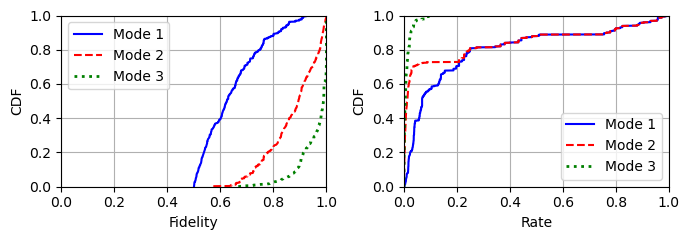

In [30]:
# Entry point
if __name__ == "__main__":
    # Generate the random connected graph
    nodes = 20
    np.random.seed(10)  # for reproducibility
    random.seed(10)
    probability = 0.001  # 1, 0.1, 0.01, 0.001
    G = gnp_random_connected_graph(nodes, probability)

    # Assign properties to edges
    for u, v in G.edges():
        G[u][v]['fidelity'] = np.random.uniform(low=0.65, high=0.99)
        G[u][v]['rate'] = np.random.uniform(low=0.75, high=1)
        G[u][v]['pur_round'] = np.random.randint(low=3, high=7)

    # Assign properties to nodes
    for node in G.nodes():
        G.nodes[node]['swap_success'] = np.random.uniform(low=0.23, high=0.8)

    graph_name = f"Random-{nodes}-probability-{probability}"

    # Prepare for simulation
    N = 1000  # Number of iterations
    eps = 15000  # Number of episodes per agent
    modes = [1, 2, 3]  # Simulation modes

    # Initialize data storage for results
    mode_1_res = []
    mode_2_res = []
    mode_3_res = []

    # Initialize data storage for results
    mode_1_fid, mode_1_rate = [], []
    mode_2_fid, mode_2_rate = [], []
    mode_3_fid, mode_3_rate = [], []

    # Generate the random source-destination pairs for parallel processing
    pairs = [(np.random.randint(low=0, high=nodes), np.random.randint(low=0, high=nodes)) for _ in range(N)]
    pairs = [pair for pair in pairs if pair[0] != pair[1]]  # Remove pairs with same source and destination

    # Define the pool for parallel execution
    with Pool(processes=8) as pool:  # Adjust the number of processes as needed
        # Initialize progress bar
        results = list(tqdm(pool.imap(simulate_source_destination, 
                                      [(G, sn, dest, modes, graph_name, eps) for sn, dest in pairs]),
                            desc="Running Simulations", total=len(pairs)))

    # Collect results
    raw_results = []
    for result in results:
        for mode, best_fid, best_rate, sn, dest, path_len, ext_path_len in result:
            raw_results.append((mode, sn, dest, best_fid, best_rate, path_len, ext_path_len))
        
            if best_fid is not None:
                if mode == 1:
                    mode_1_res.append([sn, dest, best_fid, best_rate, path_len, ext_path_len])
                    mode_1_fid.append(best_fid)
                    mode_1_rate.append(best_rate)
                elif mode == 2:
                    mode_2_res.append([sn, dest, best_fid, best_rate, path_len, ext_path_len])
                    mode_2_fid.append(best_fid)
                    mode_2_rate.append(best_rate)
                elif mode == 3:
                    mode_3_res.append([sn, dest, best_fid, best_rate, path_len, ext_path_len])
                    mode_3_fid.append(best_fid)
                    mode_3_rate.append(best_rate)
    
    # Saving raw results
    fname = f"nodes_{nodes}_N_{N}_Episodes_{eps}_Probability_{int(1000*probability)}_raw.dat"
    fname_CDF = f"nodes_{nodes}_N_{N}_Episodes_{eps}_Probability_{int(1000*probability)}_CDF.dat"
    # Find the minimum length among all arrays
    #kk = min(len(arr) for arr in [mode_1_fid, mode_1_rate, mode_2_fid, mode_2_rate, mode_3_fid, mode_3_rate])
    
    # Truncate each array to the minimum length
    # mode_1_fid, mode_1_rate, mode_2_fid, mode_2_rate, mode_3_fid, mode_3_rate = \
    # [arr[:kk] for arr in [mode_1_fid, mode_1_rate, mode_2_fid, mode_2_rate, mode_3_fid, mode_3_rate]]
    
    # Flatten each mode's results into a single 2D array
    mode_1_array = np.array(mode_1_res)
    mode_2_array = np.array(mode_2_res)
    mode_3_array = np.array(mode_3_res)

    kk = min(len(arr) for arr in [mode_1_array, mode_2_array, mode_3_array])
    
    # Truncate each array to the minimum length
    mode_1_array, mode_2_array, mode_3_array = \
    [arr[:kk] for arr in [mode_1_array, mode_2_array, mode_3_array]]
    
    # Concatenate along axis 1 (columns) to align results by mode
    data = np.hstack([
        np.pad(mode_1_array, ((0, max(0, len(mode_2_array) - len(mode_1_array))), (0, 0))),
        np.pad(mode_2_array, ((0, max(0, len(mode_1_array) - len(mode_2_array))), (0, 0))),
        np.pad(mode_3_array, ((0, max(0, len(mode_1_array) - len(mode_3_array))), (0, 0)))
    ])#print(mode_1_res)
    np.savetxt(f"data_clean_v3/{fname}",data, delimiter = "\t",
              header = f"S1\tD1\tF1\tR1\tL1\tP1\tS2\tD2\tF2\tR2\tL2\tP2\tS3\tD3\tF3\tR3\tL3\tP3", comments = "")

    # plotting and saving CDF results
    kk = min(len(arr) for arr in [mode_1_fid, mode_1_rate, mode_2_fid, mode_2_rate, mode_3_fid, mode_3_rate])
    
    # Truncate each array to the minimum length
    mode_1_fid, mode_1_rate, mode_2_fid, mode_2_rate, mode_3_fid, mode_3_rate = \
    [arr[:kk] for arr in [mode_1_fid, mode_1_rate, mode_2_fid, mode_2_rate, mode_3_fid, mode_3_rate]]
    plot_results(mode_1_fid, mode_1_rate, mode_2_fid, mode_2_rate, mode_3_fid, mode_3_rate, fname_CDF)
    